In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Set random seed for reproducibility
np.random.seed(42)


In [3]:
# Load dataset
try:
    df = pd.read_csv('/content/bankloans.csv')
    print('Dataset loaded successfully.')
except FileNotFoundError:
    print('Error: bankloans.csv not found. Please upload to /content/ in Colab.')
    raise

Dataset loaded successfully.


In [4]:

# Check missing values
print('\nMissing Values:')
print(df.isnull().sum())


Missing Values:
age           0
ed            0
employ        0
address       0
income        0
debtinc       0
creddebt      0
othdebt       0
default     450
dtype: int64


In [5]:
# Handle missing values (drop rows)
df = df.dropna()
print(f'\nDataset size after dropping missing values: {df.shape}')



Dataset size after dropping missing values: (700, 9)


In [7]:
# Feature engineering
df['debt_income_interaction'] = df['income'] * df['debtinc']
df['high_debt_ratio'] = (df['debtinc'] > 10).astype(int)

In [8]:
# Convert target to classical labels
df['creditworthiness'] = df['default'].map({0: 'Good', 1: 'Poor'})
print('\nFirst 5 rows with engineered features and labels:')
print(df.head())


First 5 rows with engineered features and labels:
   age  ed  employ  address  income  debtinc   creddebt   othdebt  default  \
0   41   3      17       12     176      9.3  11.359392  5.008608      1.0   
1   27   1      10        6      31     17.3   1.362202  4.000798      0.0   
2   40   1      15       14      55      5.5   0.856075  2.168925      0.0   
3   41   1      15       14     120      2.9   2.658720  0.821280      0.0   
4   24   2       2        0      28     17.3   1.787436  3.056564      1.0   

   debt_income_interaction  high_debt_ratio creditworthiness  
0                   1636.8                0             Poor  
1                    536.3                1             Good  
2                    302.5                0             Good  
3                    348.0                0             Good  
4                    484.4                1             Poor  


In [9]:
# Define features and target
features = ['age', 'ed', 'employ', 'address', 'income', 'debtinc', 'creddebt', 'othdebt',
            'debt_income_interaction', 'high_debt_ratio']
X = df[features].values
y = df['default'].values  # Use numeric target for modeling


In [10]:
# Split data (80-20)
n = len(X)
indices = np.arange(n)
np.random.shuffle(indices)
train_size = int(0.8 * n)
X_train, X_test = X[indices[:train_size]], X[indices[train_size:]]
y_train, y_test = y[indices[:train_size]], y[indices[train_size:]]
print(f'\nTraining set size: {X_train.shape}, Test set size: {X_test.shape}')



Training set size: (560, 10), Test set size: (140, 10)


In [11]:
# Standardize features
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
std[std == 0] = 1  # Avoid division by zero
X_train_scaled = (X_train - mean) / std
X_test_scaled = (X_test - mean) / std

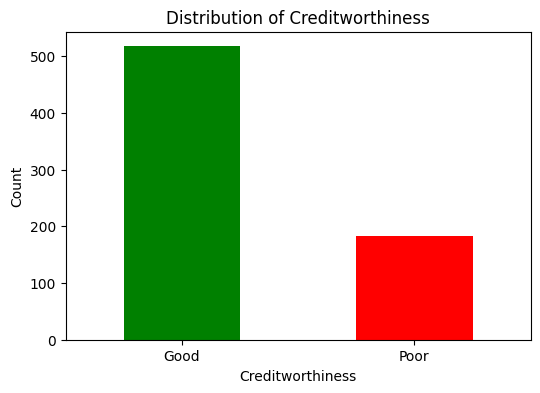


Creditworthiness Distribution:
creditworthiness
Good    0.738571
Poor    0.261429
Name: proportion, dtype: float64


In [12]:
# Visualize distribution of creditworthiness
plt.figure(figsize=(6, 4))
df['creditworthiness'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Distribution of Creditworthiness')
plt.xlabel('Creditworthiness')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# Display class distribution
print('\nCreditworthiness Distribution:')
print(df['creditworthiness'].value_counts(normalize=True))

In [15]:
# Logistic Regression
def sigmoid(z):
    return 1 / (1 + np.exp(-np.clip(z, -500, 500)))

def logistic_regression_fit(X, y, lr=0.01, epochs=1000):
    n_samples, n_features = X.shape
    weights = np.zeros(n_features)
    bias = 0
    for _ in range(epochs):
        linear_model = np.dot(X, weights) + bias
        y_pred = sigmoid(linear_model)
        dw = (1 / n_samples) * np.dot(X.T, (y_pred - y))
        db = (1 / n_samples) * np.sum(y_pred - y)
        weights -= lr * dw
        bias -= lr * db
    return weights, bias

def logistic_regression_predict(X, weights, bias):
    return (sigmoid(np.dot(X, weights) + bias) >= 0.5).astype(int)

def logistic_regression_proba(X, weights, bias):
    return sigmoid(np.dot(X, weights) + bias)


In [13]:

# Decision Tree
def gini_impurity(y):
    _, counts = np.unique(y, return_counts=True)
    probs = counts / len(y)
    return 1 - np.sum(probs ** 2)

def decision_tree_split(X, y):
    best_split = {'feature': None, 'threshold': None, 'gini': 1, 'left_X': None, 'left_y': None, 'right_X': None, 'right_y': None}
    n_features = X.shape[1]

    for feature in range(n_features):
        thresholds = np.unique(X[:, feature])
        for threshold in thresholds:
            left_mask = X[:, feature] <= threshold
            right_mask = ~left_mask
            if sum(left_mask) == 0 or sum(right_mask) == 0:
                continue
            gini_left = gini_impurity(y[left_mask])
            gini_right = gini_impurity(y[right_mask])
            gini = (sum(left_mask) * gini_left + sum(right_mask) * gini_right) / len(y)
            if gini < best_split['gini']:
                best_split = {
                    'feature': feature, 'threshold': threshold, 'gini': gini,
                    'left_X': X[left_mask], 'left_y': y[left_mask],
                    'right_X': X[right_mask], 'right_y': y[right_mask]
                }
    return best_split

def decision_tree_fit(X, y, max_depth=3, depth=0):
    if depth >= max_depth or len(np.unique(y)) == 1:
        return {'class': np.bincount(y).argmax()}
    split = decision_tree_split(X, y)
    if split['feature'] is None:
        return {'class': np.bincount(y).argmax()}
    left_tree = decision_tree_fit(split['left_X'], split['left_y'], max_depth, depth + 1)
    right_tree = decision_tree_fit(split['right_X'], split['right_y'], max_depth, depth + 1)
    return {'feature': split['feature'], 'threshold': split['threshold'], 'left': left_tree, 'right': right_tree}

def decision_tree_predict(X, tree):
    predictions = np.zeros(len(X))
    for i in range(len(X)):
        node = tree
        while 'class' not in node:
            if X[i, node['feature']] <= node['threshold']:
                node = node['left']
            else:
                node = node['right']
        predictions[i] = node['class']
    return predictions.astype(int)


In [14]:
# Random Forest
def random_forest_fit(X, y, n_trees=10, max_depth=3, sample_ratio=0.8):
    trees = []
    n_samples = len(X)
    sample_size = int(sample_ratio * n_samples)
    for _ in range(n_trees):
        indices = np.random.choice(n_samples, sample_size, replace=True)
        X_sample, y_sample = X[indices], y[indices]
        tree = decision_tree_fit(X_sample, y_sample, max_depth)
        trees.append(tree)
    return trees

def random_forest_predict(X, trees):
    predictions = np.array([decision_tree_predict(X, tree) for tree in trees])
    return np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions)

In [24]:
def compute_metrics(y_true, y_pred, y_prob=None):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    tn = np.sum((y_true == 0) & (y_pred == 0))

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    roc_auc = 0
    fpr = []
    tpr = []
    if y_prob is not None:
        sorted_indices = np.argsort(y_prob)[::-1]
        y_true_sorted = y_true[sorted_indices]
        thresholds = y_prob[sorted_indices]
        tpr, fpr = [], []
        pos = np.sum(y_true == 1)
        neg = np.sum(y_true == 0)
        tp_count, fp_count = 0, 0
        for i in range(len(y_true)):
            if i > 0 and thresholds[i] != thresholds[i-1]:
                tpr.append(tp_count / pos if pos > 0 else 0)
                fpr.append(fp_count / neg if neg > 0 else 0)
            if y_true_sorted[i] == 1:
                tp_count += 1
            else:
                fp_count += 1
        tpr.append(tp_count / pos if pos > 0 else 0)
        fpr.append(fp_count / neg if neg > 0 else 0)
        roc_auc = np.trapz(tpr, fpr)

    return precision, recall, f1, roc_auc, fpr, tpr

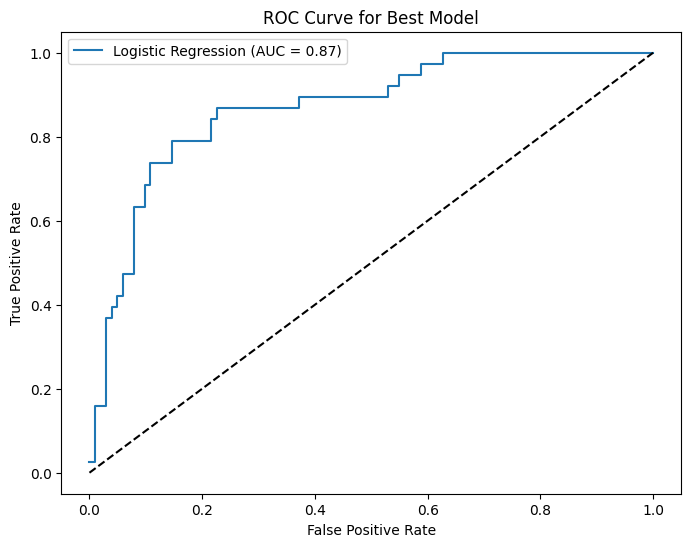

In [19]:
# Plot ROC curve for best model (if Logistic Regression)
if best_model_name == 'Logistic Regression' and best_fpr is not None:
    plt.figure(figsize=(8, 6))
    plt.plot(best_fpr, best_tpr, label=f'{best_model_name} (AUC = {best_roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Best Model')
    plt.legend()
    plt.show()
elif best_model_name in ['Decision Tree', 'Random Forest'] and best_fpr and best_tpr:
    plt.figure(figsize=(8, 6))
    plt.plot(best_fpr, best_tpr, label=f'{best_model_name} (AUC = {best_roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Best Model')
    plt.legend()
    plt.show()
else:
    print(f"ROC curve cannot be plotted for the best model ({best_model_name}) as it's not Logistic Regression or ROC AUC data is not available.")

In [25]:
# Train and evaluate models
results = {}
best_roc_auc = 0
best_model = None
best_model_name = None
best_params = None
best_fpr = None
best_tpr = None

# Logistic Regression with hyperparameter tuning
lr_params = [(0.01, 1000), (0.001, 2000)]
for lr, epochs in lr_params:
    weights, bias = logistic_regression_fit(X_train_scaled, y_train, lr=lr, epochs=epochs)
    y_pred = logistic_regression_predict(X_test_scaled, weights, bias)
    y_prob = logistic_regression_proba(X_test_scaled, weights, bias)
    precision, recall, f1, roc_auc, fpr, tpr = compute_metrics(y_test, y_pred, y_prob)
    results[f'Logistic Regression (lr={lr}, epochs={epochs})'] = {'Precision': precision, 'Recall': recall, 'F1-Score': f1, 'ROC-AUC': roc_auc}
    if roc_auc > best_roc_auc:
        best_roc_auc = roc_auc
        best_model = (weights, bias)
        best_model_name = 'Logistic Regression'
        best_params = (lr, epochs)
        best_fpr = fpr
        best_tpr = tpr

# Convert y_train and y_test to integer type for tree-based models
y_train_int = y_train.astype(int)
y_test_int = y_test.astype(int)

# Decision Tree with hyperparameter tuning
dt_params = [2, 3, 5] # max_depth
for max_depth in dt_params:
    tree = decision_tree_fit(X_train_scaled, y_train_int, max_depth=max_depth)
    y_pred = decision_tree_predict(X_test_scaled, tree)
    precision, recall, f1, roc_auc, fpr, tpr = compute_metrics(y_test_int, y_pred) # ROC AUC not directly available for DT
    results[f'Decision Tree (max_depth={max_depth})'] = {'Precision': precision, 'Recall': recall, 'F1-Score': f1, 'ROC-AUC': roc_auc if roc_auc != 0 else 'N/A'} # Handle cases where ROC AUC is 0 or not applicable
    if roc_auc > best_roc_auc:
        best_roc_auc = roc_auc
        best_model = tree
        best_model_name = 'Decision Tree'
        best_params = (max_depth,)
        best_fpr = fpr # FPR and TPR will be empty lists if ROC AUC is N/A or 0
        best_tpr = tpr

# Random Forest with hyperparameter tuning
rf_params = [(10, 3, 0.8), (20, 5, 0.7)] # n_trees, max_depth, sample_ratio
for n_trees, max_depth, sample_ratio in rf_params:
    forest = random_forest_fit(X_train_scaled, y_train_int, n_trees=n_trees, max_depth=max_depth, sample_ratio=sample_ratio)
    y_pred = random_forest_predict(X_test_scaled, forest)
    precision, recall, f1, roc_auc, fpr, tpr = compute_metrics(y_test_int, y_pred) # ROC AUC not directly available for RF
    results[f'Random Forest (n_trees={n_trees}, max_depth={max_depth}, sample_ratio={sample_ratio})'] = {'Precision': precision, 'Recall': recall, 'F1-Score': f1, 'ROC-AUC': roc_auc if roc_auc != 0 else 'N/A'}
    if roc_auc > best_roc_auc:
        best_roc_auc = roc_auc
        best_model = forest
        best_model_name = 'Random Forest'
        best_params = (n_trees, max_depth, sample_ratio)
        best_fpr = fpr # FPR and TPR will be empty lists if ROC AUC is N/A or 0
        best_tpr = tpr

# Print results
print('\nModel Evaluation Results:')
for model, metrics in results.items():
    print(f'{model}:')
    for metric, value in metrics.items():
        print(f'  {metric}: {value:.4f}' if isinstance(value, (int, float)) else f'  {metric}: {value}')

print(f'\nBest Model: {best_model_name} with parameters {best_params} (ROC AUC: {best_roc_auc:.4f})')

/tmp/ipython-input-24-4166197765.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc = np.trapz(tpr, fpr)



Model Evaluation Results:
Logistic Regression (lr=0.01, epochs=1000):
  Precision: 0.7500
  Recall: 0.4737
  F1-Score: 0.5806
  ROC-AUC: 0.8687
Logistic Regression (lr=0.001, epochs=2000):
  Precision: 0.6667
  Recall: 0.6316
  F1-Score: 0.6486
  ROC-AUC: 0.8540
Decision Tree (max_depth=2):
  Precision: 0.5417
  Recall: 0.3421
  F1-Score: 0.4194
  ROC-AUC: N/A
Decision Tree (max_depth=3):
  Precision: 0.5714
  Recall: 0.4211
  F1-Score: 0.4848
  ROC-AUC: N/A
Decision Tree (max_depth=5):
  Precision: 0.6176
  Recall: 0.5526
  F1-Score: 0.5833
  ROC-AUC: N/A
Random Forest (n_trees=10, max_depth=3, sample_ratio=0.8):
  Precision: 0.5806
  Recall: 0.4737
  F1-Score: 0.5217
  ROC-AUC: N/A
Random Forest (n_trees=20, max_depth=5, sample_ratio=0.7):
  Precision: 0.6452
  Recall: 0.5263
  F1-Score: 0.5797
  ROC-AUC: N/A

Best Model: Logistic Regression with parameters (0.01, 1000) (ROC AUC: 0.8687)


In [26]:
def get_user_input():
    print('\nEnter the following feature values for creditworthiness prediction:')
    features = {}

    try:
        features['age'] = float(input('Age (e.g., 20-60): '))
        if not 18 <= features['age'] <= 100:
            raise ValueError('Age must be between 18 and 100.')

        features['ed'] = float(input('Education level (1=High School, 2=Some College, 3=College, 4=Master’s, 5=PhD): '))
        if features['ed'] not in [1, 2, 3, 4, 5]:
            raise ValueError('Education must be between 1 and 5.')

        features['employ'] = float(input('Years employed (e.g., 0-30): '))
        if features['employ'] < 0:
            raise ValueError('Years employed cannot be negative.')

        features['address'] = float(input('Years at current address (e.g., 0-30): '))
        if features['address'] < 0:
            raise ValueError('Years at address cannot be negative.')

        features['income'] = float(input('Annual income in thousands (e.g., 10-500): '))
        if features['income'] < 0:
            raise ValueError('Income cannot be negative.')

        features['debtinc'] = float(input('Debt-to-income ratio (e.g., 0.1-50): '))
        if features['debtinc'] < 0:
            raise ValueError('Debt-to-income ratio cannot be negative.')

        features['creddebt'] = float(input('Credit debt in thousands (e.g., 0-20): '))
        if features['creddebt'] < 0:
            raise ValueError('Credit debt cannot be negative.')

        features['othdebt'] = float(input('Other debt in thousands (e.g., 0-20): '))
        if features['othdebt'] < 0:
            raise ValueError('Other debt cannot be negative.')

        # Compute engineered features
        features['debt_income_interaction'] = features['income'] * features['debtinc']
        features['high_debt_ratio'] = 1 if features['debtinc'] > 10 else 0

        return features

    except ValueError as e:
        print(f'Invalid input: {e}. Please enter valid numerical values.')
        return None

def predict_creditworthiness(new_data, mean, std, model, model_type):
    if isinstance(new_data, dict):
        new_data = pd.DataFrame([new_data])

    required_columns = ['age', 'ed', 'employ', 'address', 'income', 'debtinc', 'creddebt',
                       'othdebt', 'debt_income_interaction', 'high_debt_ratio']
    if not all(col in new_data.columns for col in required_columns):
        missing_cols = [col for col in required_columns if col not in new_data.columns]
        raise ValueError(f'Missing columns in new_data: {missing_cols}')

    X_new = new_data[required_columns].values
    X_new_scaled = (X_new - mean) / std

    if model_type == 'Logistic Regression':
        weights, bias = model
        prediction = logistic_regression_predict(X_new_scaled, weights, bias)
    elif model_type == 'Decision Tree':
        prediction = decision_tree_predict(X_new_scaled, model)
    else:  # Random Forest
        prediction = random_forest_predict(X_new_scaled, model)

    return 'Good (No default)' if prediction[0] == 0 else 'Poor (Default)'

# Interactive prediction loop
print(f'\nUsing Best Model: {best_model_name} with params {best_params}')
while True:
    user_features = get_user_input()
    if user_features is None:
        retry = input('Would you like to try again? (yes/no): ').lower()
        if retry != 'yes':
            break
        continue

    try:
        predicted_class = predict_creditworthiness(user_features, mean, std, best_model, best_model_name)
        print(f'\nPredicted Creditworthiness: {predicted_class}')
    except Exception as e:
        print(f'Error during prediction: {e}')

    retry = input('Would you like to predict for another individual? (yes/no): ').lower()
    if retry != 'yes':
        break


Using Best Model: Logistic Regression with params (0.01, 1000)

Enter the following feature values for creditworthiness prediction:
Age (e.g., 20-60): 23
Education level (1=High School, 2=Some College, 3=College, 4=Master’s, 5=PhD): 4
Years employed (e.g., 0-30): 26
Years at current address (e.g., 0-30): 25
Annual income in thousands (e.g., 10-500): 426
Debt-to-income ratio (e.g., 0.1-50): 42
Credit debt in thousands (e.g., 0-20): 16
Other debt in thousands (e.g., 0-20): 12

Predicted Creditworthiness: Poor (Default)
Would you like to predict for another individual? (yes/no): yes

Enter the following feature values for creditworthiness prediction:
Age (e.g., 20-60): 56
Education level (1=High School, 2=Some College, 3=College, 4=Master’s, 5=PhD): 1
Years employed (e.g., 0-30): 23
Years at current address (e.g., 0-30): 12
Annual income in thousands (e.g., 10-500): 223
Debt-to-income ratio (e.g., 0.1-50): 23
Credit debt in thousands (e.g., 0-20): 1
Other debt in thousands (e.g., 0-20): 